In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_users = pd.read_csv('takehome_users.csv', sep="\\|,\\|", engine='python')

In [3]:
names = df_users.columns.str.split(',').tolist()

In [4]:
names = names[0]

In [5]:
df_users = df_users.iloc[:,0].str.split(',', expand=True)

In [6]:
df_users.columns = names

In [7]:
df_users.object_id = df_users.object_id.astype(int)

In [8]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240


In [9]:
df_usereng = pd.read_csv('takehome_user_engagement.csv')

In [10]:
df_usereng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Analysis of users engagment dataframe:

In [11]:
df_usereng.isna().any()

time_stamp    False
user_id       False
visited       False
dtype: bool

In [12]:
df_usereng.visited.unique()

array([1])

In [13]:
df_usereng.user_id.nunique()

8823

In [14]:
df_usereng.user_id.max()

12000

In [15]:
df_usereng.time_stamp.dtype

dtype('O')

In [16]:
df_usereng.time_stamp = pd.to_datetime(df_usereng.time_stamp)

In [17]:
df_usereng = df_usereng.sort_values('time_stamp')

In [18]:
df_usereng = df_usereng.set_index('time_stamp')

In [19]:
temp = df_usereng.groupby('user_id')['visited'].rolling('7D', min_periods=1).count()

In [20]:
df_usereng = df_usereng.sort_values('user_id')

In [21]:
df_usereng['rolling_engagment'] = temp.values

In [22]:
temp = df_usereng.groupby('user_id')['rolling_engagment'].max()

In [23]:
adopted_user = temp >= 3

In [24]:
df_adopted_user = pd.DataFrame(adopted_user)

In [25]:
df_adopted_user = df_adopted_user.rename(columns={'rolling_engagment':'adopted_user'})

Analysis of users dataframe:

In [26]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240


In [27]:
df_users = df_users.replace("", np.nan)

In [28]:
df_users.isna().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool

The missing values in invited_by_user_id probably represent users that signed up without an invitation. We check for this:

In [29]:
df_users[df_users['invited_by_user_id'].isna()]['creation_source'].unique()

array(['SIGNUP', 'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [30]:
df_users[~df_users['invited_by_user_id'].isna()]['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE'], dtype=object)

We see that our assumption was correct. We impute these values with "not invited".

In [31]:
df_users.loc[df_users['invited_by_user_id'].isna(), 'invited_by_user_id'] = 'not invited'

The missing values in last_session_creation_time probably represent users that never logged in to their accounts after account creation. We first check this by merging the original user engagment dataframe with the users dataframe to see if there are any usages recorded in the original user engagment dataframe.

In [32]:
temp = pd.read_csv('takehome_user_engagement.csv')

In [33]:
dftemp = df_users.merge(temp, how='left', left_on='object_id', right_on='user_id')

In [34]:
dftemp[dftemp['last_session_creation_time'].isna()].shape[0]

3177

In [35]:
dftemp.loc[dftemp['last_session_creation_time'].isna(), 'visited'].isna().sum()

3177

We see that merging the dataframes did not help in imputing the missing data for last_session_creation_time. So we reiterate our assumption that the missing values in last_session_creation_time probably represent users that never logged in to their accounts after account creation. We impute these values to be the same as account creation time.

In [36]:
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')

In [37]:
df_users.creation_time = pd.to_datetime(df_users['creation_time'])

In [38]:
df_users.loc[df_users['last_session_creation_time'].isna(), 'last_session_creation_time'] = \
df_users.loc[df_users['last_session_creation_time'].isna(), 'creation_time']

In [39]:
(df_users.creation_time > df_users.last_session_creation_time).any()

False

In [40]:
df_users[df_users['name'].duplicated(keep=False)].sort_values('name').head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6696,6697,2013-11-11 04:10:17,Alexander Zoe,ZoeAlexander@yahoo.com,PERSONAL_PROJECTS,2013-11-11 04:10:17,0,0,230,not invited
5768,5769,2013-07-24 00:55:06,Alexander Zoe,ZoeAlexander@gustr.com,SIGNUP,2013-07-25 00:55:06,0,0,32,not invited
6420,6421,2013-03-29 22:05:46,Almeida Aline,AlineBarbosaAlmeida@jourrapide.com,PERSONAL_PROJECTS,2013-03-31 22:05:46,0,0,8,not invited
5105,5106,2012-09-12 21:35:02,Almeida Aline,AlineSousaAlmeida@gmail.com,SIGNUP,2012-09-12 21:35:02,0,0,79,not invited
9710,9711,2013-06-03 06:28:46,Almeida Andr�,AndreCorreiaAlmeida@hotmail.com,SIGNUP,2013-06-03 06:28:46,0,0,44,not invited


In [41]:
df_users[df_users['name'].duplicated(keep=False)].shape

(1218, 10)

There are users with the same name but different information on the other columns. We need more info to check whether these are the same people (who might have changed organization for example and got a new account). For now, we suppose they are different people.

In [42]:
df_users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list              object
enabled_for_marketing_drip            object
org_id                                object
invited_by_user_id                    object
dtype: object

In [43]:
df_users['opted_in_to_mailing_list'] = pd.to_numeric(df_users['opted_in_to_mailing_list']).astype('bool')
df_users['enabled_for_marketing_drip'] = pd.to_numeric(df_users['enabled_for_marketing_drip']).astype('bool')
df_users['org_id'] = df_users['org_id'].astype('category')
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].astype('category')

In [44]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240


In [45]:
df = df_users.merge(df_adopted_user, how='left', left_on='object_id', right_on='user_id')

There are some users in the users dataframe for which there is no data available in the user engagment dataframe. The best guess we can make here is that these users have had no engagment and are thus not adopted users. In the merged dataframe, adopted user value for these users is NaN. So we convert these NaNs into False (not adopted).

In [46]:
df['adopted_user'] = df['adopted_user'].replace(np.nan,False)

Feature engineering: (we need today's date to create features but since we don't have that for this problem, we will use the last day an account was accessed)

In [47]:
df['days_since_last_login'] = (df['last_session_creation_time'].max().date() - \
          df['last_session_creation_time'].dt.date).dt.days.astype(int)

In [48]:
df['days_since_account_creation'] = (df['last_session_creation_time'].max().date() - \
          df['creation_time'].dt.date).dt.days.astype(int)

In [49]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_last_login,days_since_account_creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803,False,45,45
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316,True,67,203
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525,False,444,444
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151,False,380,381
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240,False,500,505


We perform exploratory data analysis

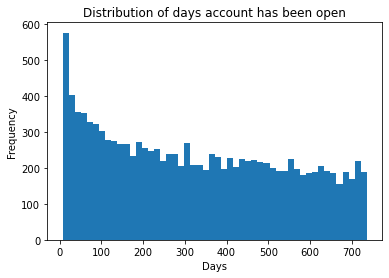

In [50]:
fig, ax = plt.subplots()
ax.hist(df['days_since_account_creation'], bins=50)
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of days account has been open')
plt.show()

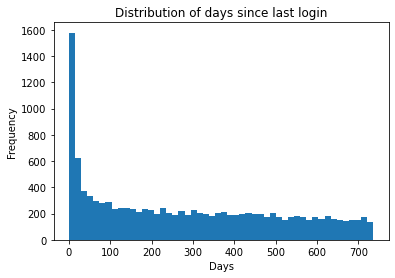

In [51]:
fig, ax = plt.subplots()
ax.hist(df['days_since_last_login'], bins=50)
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of days since last login')
plt.show()

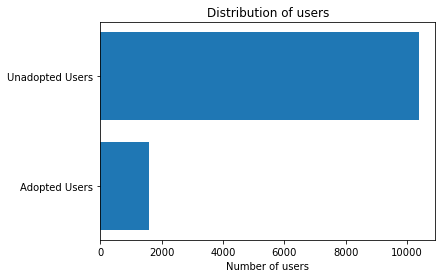

In [52]:
adopted_user = len(df[df['adopted_user'] == True])
unadopted_user = len(df[df['adopted_user'] == False])
fig, ax = plt.subplots()
ax.barh(np.arange(1,3),[adopted_user,unadopted_user])
ax.set_xlabel('Number of users')
ax.set_yticks(np.arange(1,3))
ax.set_yticklabels(['Adopted Users', 'Unadopted Users'])
ax.set_title('Distribution of users')
plt.show()

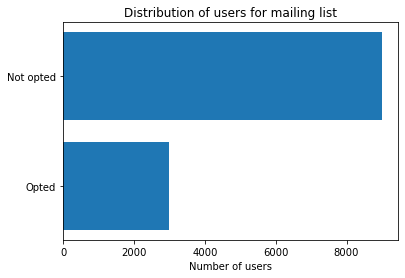

In [53]:
opted_mailing_list = len(df[df['opted_in_to_mailing_list'] == True])
not_opted = len(df[df['opted_in_to_mailing_list'] == False])
fig, ax = plt.subplots()
ax.barh(np.arange(1,3),[opted_mailing_list,not_opted])
ax.set_xlabel('Number of users')
ax.set_yticks(np.arange(1,3))
ax.set_yticklabels(['Opted', 'Not opted'])
ax.set_title('Distribution of users for mailing list')
plt.show()

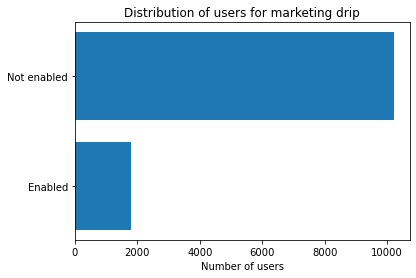

In [54]:
enabled_marketing = len(df[df['enabled_for_marketing_drip'] == True])
not_enabled = len(df[df['enabled_for_marketing_drip'] == False])
fig, ax = plt.subplots()
ax.barh(np.arange(1,3),[enabled_marketing,not_enabled])
ax.set_xlabel('Number of users')
ax.set_yticks(np.arange(1,3))
ax.set_yticklabels(['Enabled', 'Not enabled'])
ax.set_title('Distribution of users for marketing drip')
plt.show()

We preprocess the data for modeling:

In [55]:
X = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', \
        'invited_by_user_id', 'days_since_last_login', 'days_since_account_creation']]
y = df[['adopted_user']]

In [56]:
X.dtypes

creation_source                  object
opted_in_to_mailing_list           bool
enabled_for_marketing_drip         bool
org_id                         category
invited_by_user_id             category
days_since_last_login             int64
days_since_account_creation       int64
dtype: object

In [57]:
y.dtypes

adopted_user    bool
dtype: object

In [58]:
y = y.astype('bool')
y.dtypes

adopted_user    bool
dtype: object

In [59]:
onehotencoded_columns = pd.get_dummies(X[['creation_source', 'org_id', 'invited_by_user_id']], drop_first = True)

In [60]:
X = pd.concat([X[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'days_since_last_login', \
              'days_since_account_creation']], pd.DataFrame(onehotencoded_columns)],axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [62]:
scaler = StandardScaler()
scaler.fit(X_train[['days_since_last_login', 'days_since_account_creation']])

StandardScaler()

In [63]:
scaled_train_columns = scaler.transform(X_train[['days_since_last_login', 'days_since_account_creation']])
scaled_test_columns = scaler.transform(X_test[['days_since_last_login', 'days_since_account_creation']])

In [64]:
X_train = pd.concat([X_train.drop(columns=['days_since_last_login', 'days_since_account_creation']).\
                   reset_index(drop=True), pd.DataFrame(scaled_train_columns, \
                   columns=['days_since_last_login','days_since_account_creation'])], axis=1)

In [65]:
X_test = pd.concat([X_test.drop(columns=['days_since_last_login', 'days_since_account_creation']).\
                   reset_index(drop=True), pd.DataFrame(scaled_test_columns, \
                   columns=['days_since_last_login','days_since_account_creation'])], axis=1)

We now perform modeling. Since we have class imbalance we try logistic regression as well as two tree based algorithms (random forest and gradient boosting) which should perform better on imbalanced data. We also try support vector classifer and include penalization for mistakes on the minority class by an amount proportional to how under-represented it is.

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [67]:
lr = LogisticRegression(random_state = 42)
lr_mean_accuracy = np.mean(cross_val_score(lr,X_train,y_train,cv=5))
lr.fit(X_train, y_train)
target_names = ['Unadopted User', 'Adopted User']
lr_cr_train = classification_report(y_train, lr.predict(X_train), target_names=target_names)
lr_cr_test = classification_report(y_test, lr.predict(X_test), target_names=target_names)
lr_accuracy_train = lr.score(X_train, y_train)
lr_accuracy_test = lr.score(X_test, y_test)
lr_roc_auc_score_train = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
lr_roc_auc_score_test = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

Mean cross validation accuracy for training set: 0.9714583333333333
Accuracy for training set: 0.97875
Accuracy for test set: 0.9754166666666667
roc-auc score for training set: 0.9963194200702279
roc-auc score for test set: 0.9922440262437068
Classification report for training set:
                 precision    recall  f1-score   support

Unadopted User       0.98      1.00      0.99      8324
  Adopted User       0.97      0.86      0.92      1276

      accuracy                           0.98      9600
     macro avg       0.98      0.93      0.95      9600
  weighted avg       0.98      0.98      0.98      9600

Classification report for test set:
                 precision    recall  f1-score   support

Unadopted User       0.98      0.99      0.99      2074
  Adopted User       0.96      0.85      0.90       326

      accuracy                           0.98      2400
     macro avg       0.97      0.92      0.94      2400
  weighted avg       0.98      0.98      0.97      2400



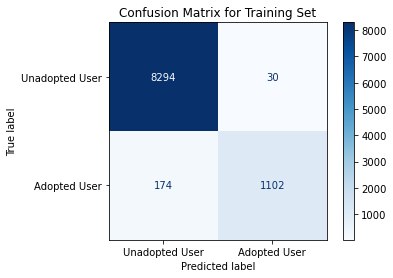

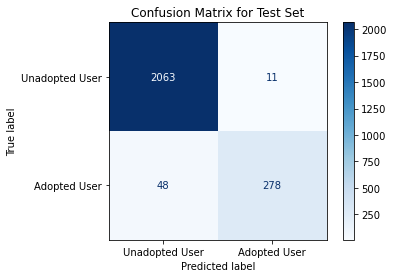

In [68]:
print('Mean cross validation accuracy for training set:', lr_mean_accuracy)
print('Accuracy for training set:', lr_accuracy_train)
print('Accuracy for test set:', lr_accuracy_test)
print('roc-auc score for training set:', lr_roc_auc_score_train)
print('roc-auc score for test set:', lr_roc_auc_score_test)
print('Classification report for training set:\n', lr_cr_train)
print('Classification report for test set:\n', lr_cr_test)
disp = plot_confusion_matrix(lr, X_train, y_train, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Training Set')
plt.show()
disp = plot_confusion_matrix(lr, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Test Set')
plt.show()

In [69]:
rf = RandomForestClassifier(random_state = 42, max_depth=3, max_leaf_nodes=5)
rf_mean_accuracy = np.mean(cross_val_score(rf,X_train,y_train,cv=5))
rf.fit(X_train, y_train)
rf_cr_train = classification_report(y_train, rf.predict(X_train), target_names=target_names)
rf_cr_test = classification_report(y_test, rf.predict(X_test), target_names=target_names)
rf_accuracy_train = rf.score(X_train, y_train)
rf_accuracy_test = rf.score(X_test, y_test)
rf_roc_auc_score_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
rf_roc_auc_score_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

Mean cross validation accuracy for training set: 0.8670833333333334
Accuracy for training set: 0.8670833333333333
Accuracy for test set: 0.8641666666666666
roc-auc score for training set: 0.676378468649778
roc-auc score for test set: 0.6093549408096739
Classification report for training set:
                 precision    recall  f1-score   support

Unadopted User       0.87      1.00      0.93      8324
  Adopted User       0.00      0.00      0.00      1276

      accuracy                           0.87      9600
     macro avg       0.43      0.50      0.46      9600
  weighted avg       0.75      0.87      0.81      9600

Classification report for test set:
                 precision    recall  f1-score   support

Unadopted User       0.86      1.00      0.93      2074
  Adopted User       0.00      0.00      0.00       326

      accuracy                           0.86      2400
     macro avg       0.43      0.50      0.46      2400
  weighted avg       0.75      0.86      0.80   

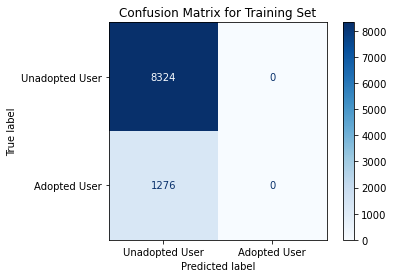

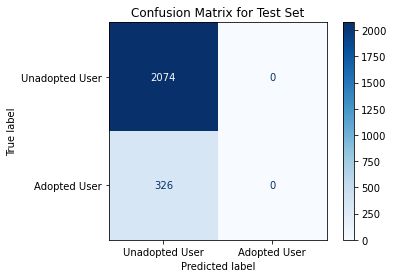

In [70]:
print('Mean cross validation accuracy for training set:', rf_mean_accuracy)
print('Accuracy for training set:', rf_accuracy_train)
print('Accuracy for test set:', rf_accuracy_test)
print('roc-auc score for training set:', rf_roc_auc_score_train)
print('roc-auc score for test set:', rf_roc_auc_score_test)
print('Classification report for training set:\n', rf_cr_train)
print('Classification report for test set:\n', rf_cr_test)
disp = plot_confusion_matrix(rf, X_train, y_train, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Training Set')
plt.show()
disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Test Set')
plt.show()

In [71]:
gb = GradientBoostingClassifier(random_state = 42, max_leaf_nodes=5)
gb_mean_accuracy = np.mean(cross_val_score(gb,X_train,y_train,cv=5))
gb.fit(X_train, y_train)
gb_cr_train = classification_report(y_train, gb.predict(X_train), target_names=target_names)
gb_cr_test = classification_report(y_test, gb.predict(X_test), target_names=target_names)
gb_accuracy_train = gb.score(X_train, y_train)
gb_accuracy_test = gb.score(X_test, y_test)
gb_roc_auc_score_train = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
gb_roc_auc_score_test = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])

Mean cross validation accuracy for training set: 0.96125
Accuracy for training set: 0.9666666666666667
Accuracy for test set: 0.9633333333333334
roc-auc score for training set: 0.9922027404235062
roc-auc score for test set: 0.981851701758849
Classification report for training set:
                 precision    recall  f1-score   support

Unadopted User       0.97      1.00      0.98      8324
  Adopted User       0.97      0.77      0.86      1276

      accuracy                           0.97      9600
     macro avg       0.97      0.88      0.92      9600
  weighted avg       0.97      0.97      0.97      9600

Classification report for test set:
                 precision    recall  f1-score   support

Unadopted User       0.96      0.99      0.98      2074
  Adopted User       0.95      0.77      0.85       326

      accuracy                           0.96      2400
     macro avg       0.96      0.88      0.91      2400
  weighted avg       0.96      0.96      0.96      2400



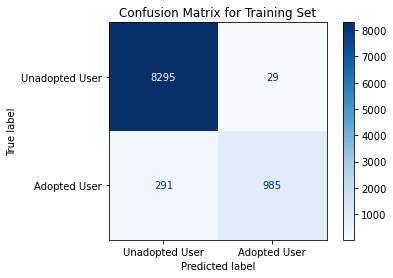

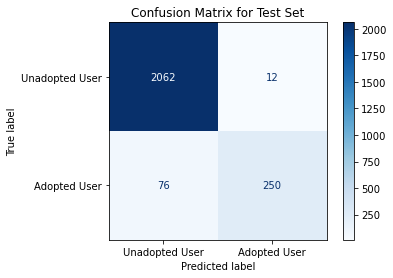

In [72]:
print('Mean cross validation accuracy for training set:', gb_mean_accuracy)
print('Accuracy for training set:', gb_accuracy_train)
print('Accuracy for test set:', gb_accuracy_test)
print('roc-auc score for training set:', gb_roc_auc_score_train)
print('roc-auc score for test set:', gb_roc_auc_score_test)
print('Classification report for training set:\n', gb_cr_train)
print('Classification report for test set:\n', gb_cr_test)
disp = plot_confusion_matrix(gb, X_train, y_train, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Training Set')
plt.show()
disp = plot_confusion_matrix(gb, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Test Set')
plt.show()

In [73]:
sv = SVC(random_state = 42, kernel='linear', class_weight='balanced', probability=True)
sv_mean_accuracy = np.mean(cross_val_score(sv,X_train,y_train,cv=5))
sv.fit(X_train, y_train)
sv_cr_train = classification_report(y_train, sv.predict(X_train), target_names=target_names)
sv_cr_test = classification_report(y_test, sv.predict(X_test), target_names=target_names)
sv_accuracy_train = sv.score(X_train, y_train)
sv_accuracy_test = sv.score(X_test, y_test)
sv_roc_auc_score_train = roc_auc_score(y_train, sv.predict_proba(X_train)[:, 1])
sv_roc_auc_score_test = roc_auc_score(y_test, sv.predict_proba(X_test)[:, 1])

Mean cross validation accuracy for training set: 0.9672916666666668
Accuracy for training set: 0.9836458333333333
Accuracy for test set: 0.9675
roc-auc score for training set: 0.9982711357723786
roc-auc score for test set: 0.9838964450307932
Classification report for training set:
                 precision    recall  f1-score   support

Unadopted User       1.00      0.98      0.99      8324
  Adopted User       0.90      0.99      0.94      1276

      accuracy                           0.98      9600
     macro avg       0.95      0.98      0.97      9600
  weighted avg       0.98      0.98      0.98      9600

Classification report for test set:
                 precision    recall  f1-score   support

Unadopted User       0.99      0.97      0.98      2074
  Adopted User       0.85      0.92      0.89       326

      accuracy                           0.97      2400
     macro avg       0.92      0.95      0.93      2400
  weighted avg       0.97      0.97      0.97      2400



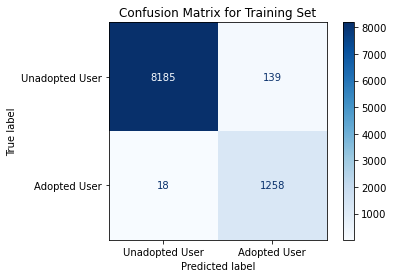

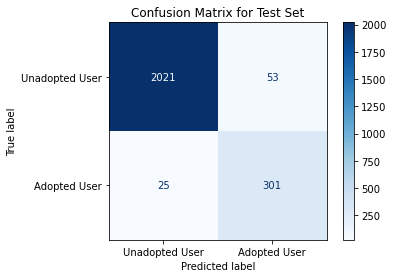

In [74]:
print('Mean cross validation accuracy for training set:', sv_mean_accuracy)
print('Accuracy for training set:', sv_accuracy_train)
print('Accuracy for test set:', sv_accuracy_test)
print('roc-auc score for training set:', sv_roc_auc_score_train)
print('roc-auc score for test set:', sv_roc_auc_score_test)
print('Classification report for training set:\n', sv_cr_train)
print('Classification report for test set:\n', sv_cr_test)
disp = plot_confusion_matrix(sv, X_train, y_train, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Training Set')
plt.show()
disp = plot_confusion_matrix(sv, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Test Set')
plt.show()

Since we have good performing models and for the sake of time, we do not perform any hyperparameter tuning. Among our models, logistic regression has the overall best performance. However, support vector classifer performs almost equivalently well and also it performs better considering the minority class, adopted users. This means that support vector classifer has the least probability to label an actually adopted user as unadopted.<br>
We now check for important features:

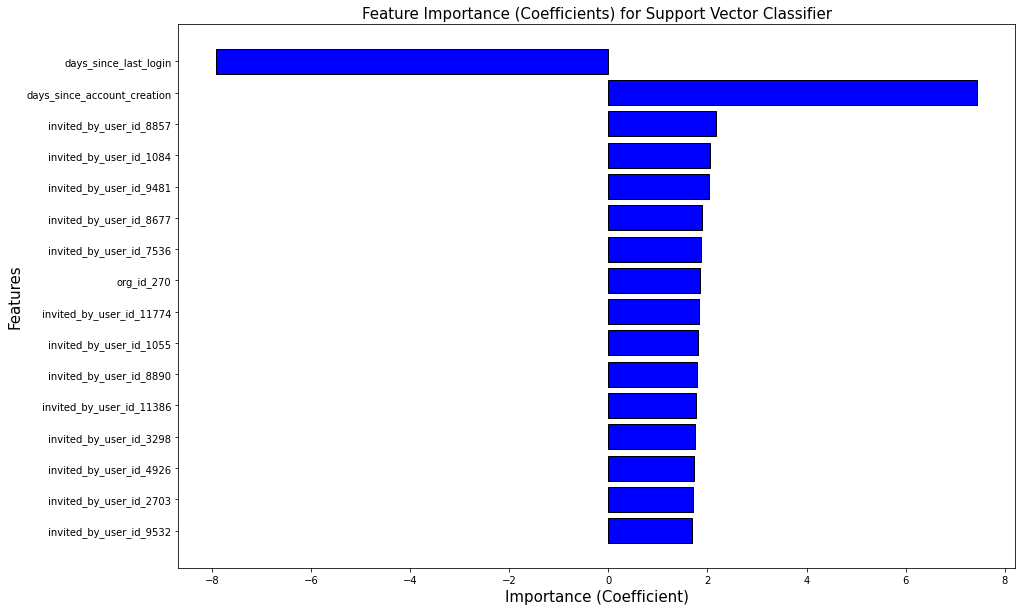

In [77]:
table = pd.DataFrame({'Features':X_train.columns, 'Importance':sv.coef_.reshape(sv.coef_.shape[1]),\
                      'ABSImportance':np.abs(sv.coef_).reshape(sv.coef_.shape[1])}).\
                                             sort_values('ABSImportance', ascending=False)
feature_importance = np.flip(table['Importance'][:16])
features = np.flip(table['Features'][:16])
plt.figure(figsize=(15,10))
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.barh(index, feature_importance, align='center', color='blue', edgecolor='k')
plt.xlabel('Importance (Coefficient)', fontsize = 15)
plt.yticks(index, features)
plt.ylabel('Features', fontsize = 15)
plt.title('Feature Importance (Coefficients) for Support Vector Classifier', fontsize=15)
plt.show()